## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

## Load Data

In [2]:
pd.set_option('display.max_columns', None)

train_df = pd.read_csv('train.csv')
train_df.head()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,Days_Difference
0,4,0,4673500.0,0.0,0.192497,0.136489,1,1,0.183775,1,18
1,2,1,2603000.0,3825.0,0.153596,0.147591,1,0,0.183775,0,12
2,3,0,440000.0,0.0,0.143342,0.144796,1,0,0.132709,0,0
3,3,1,930000.0,0.0,0.102362,0.161992,1,0,0.132709,0,0
4,5,0,10191000.0,0.0,0.153596,0.177178,1,1,0.128494,0,1


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,Days_Difference
0,2,0,2603000.0,0.0,0.198939,0.164586,1,0,0.187991,0,12
1,3,0,1080000.0,0.0,0.162498,0.170000,1,1,0.133190,0,0
2,2,1,4832000.0,0.0,0.145251,0.174562,1,0,0.187991,0,22
3,3,1,1230000.0,0.0,0.146154,0.143551,1,0,0.133190,0,0
4,2,1,4666000.0,0.0,0.194469,0.116631,1,1,0.187991,0,25


## Pre-Processing

### Check Multicollinearity of Variables

In [4]:
Z = train_df.copy()
Z['constant'] = 1

#compute VIF
vif_data = pd.DataFrame({
    'Variable': Z.columns,
    'VIF': [variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])]
})

vif_data = vif_data[vif_data['Variable'] != 'constant'].sort_values(by='VIF', ascending=False)

print(vif_data)

           Variable       VIF
0     ReserveStatus  4.528153
8           Vehicle  3.381289
9            Cancel  2.553869
2             Price  1.952987
6          Domestic  1.669377
10  Days_Difference  1.366797
7        TripReason  1.208459
5                To  1.060237
4              From  1.057195
1              Male  1.053548
3    CouponDiscount  1.015101


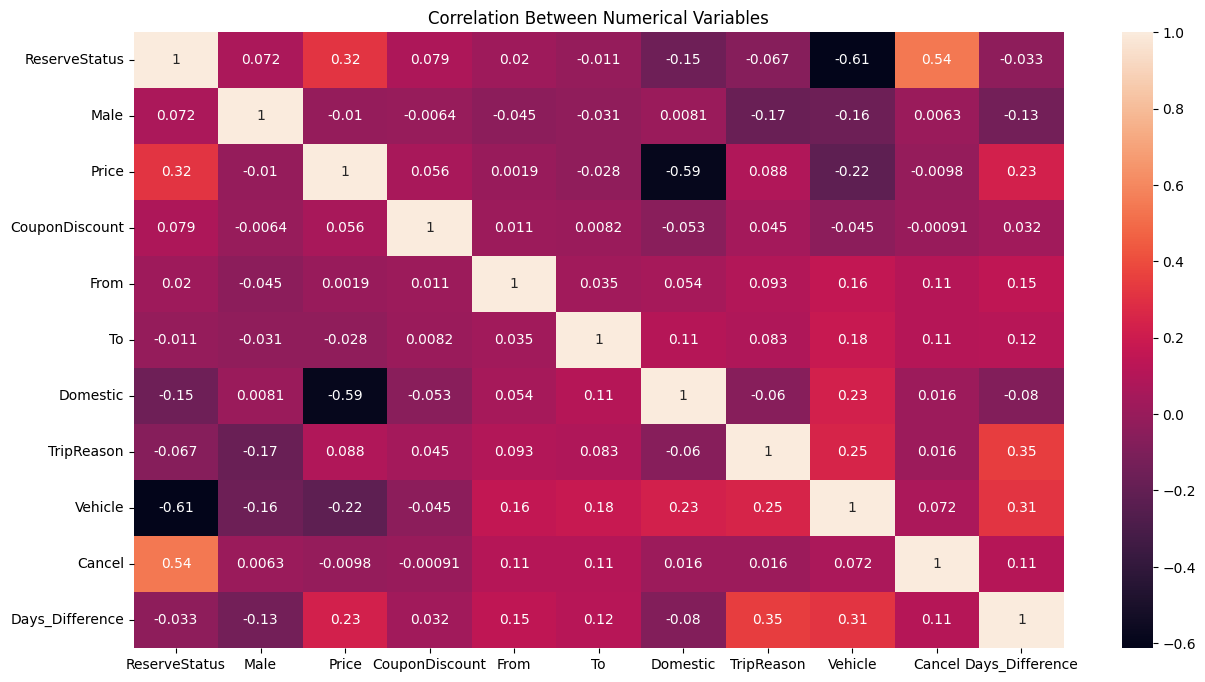

In [5]:
#check correlation
plt.figure(figsize = (15, 8))
corr = train_df.corr()
sns.heatmap(corr, annot = True)
plt.title('Correlation Between Numerical Variables')
plt.show()

**Insight:**

Although `ReserveStatus` and `Vehicle` has a very high VIF score (inf), which might indicate overrepresentation, and multicollinearity. but i decide those column will no be dropped. because the model perform much better when no column dropped.

In [6]:
#remove multicollinear variables
#train_df = train_df.drop(columns = ['Vehicle'])
#test_df = test_df.drop(columns = ['Vehicle'])

## Outlier Handling of Training Set

In [7]:
import scipy.stats as stats

In [8]:
# function to graph
def check_plot(df, variable):
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [9]:
columns_to_check = ['Price','CouponDiscount', 'Days_Difference']

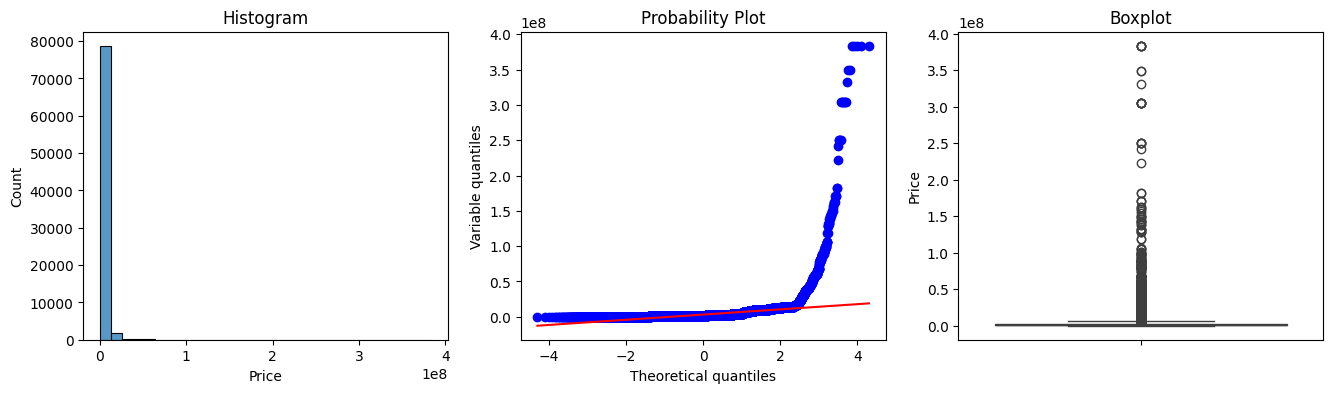

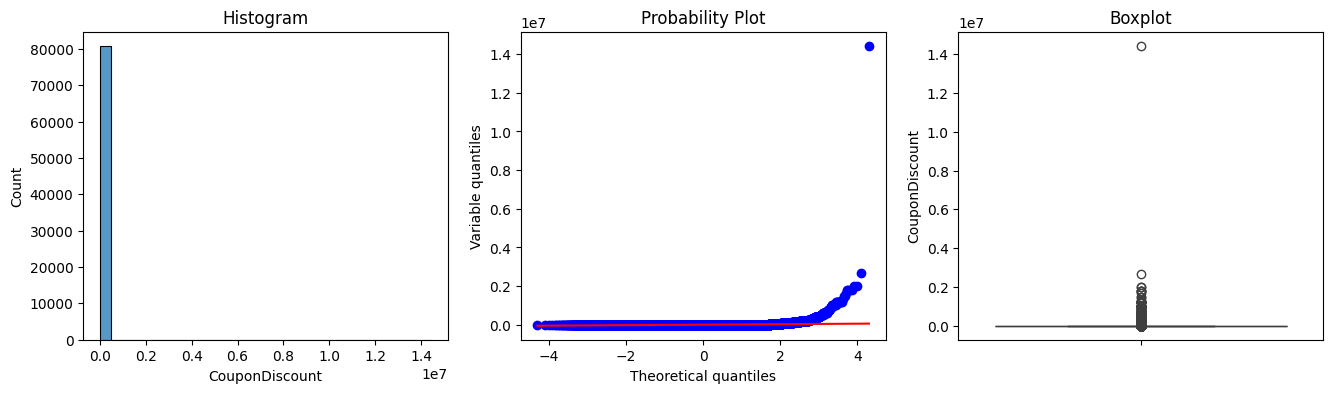

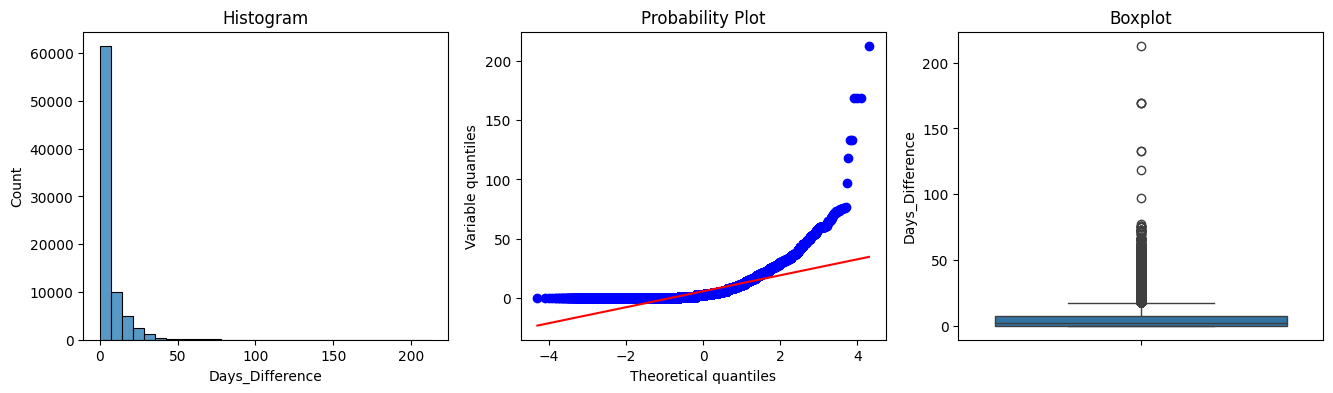

In [10]:
for col in columns_to_check:
  check_plot(train_df, col)

In [11]:
# function to find IQR of variables
def find_outlier_boundary(df, variable):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [12]:
pitch_upper_limit, pitch_lower_limit = find_outlier_boundary(train_df, 'Price')
print(f'Bounds for Price: {pitch_upper_limit, pitch_lower_limit}')


trips_upper_limit, trips_lower_limit = find_outlier_boundary(train_df, 'CouponDiscount')
print(f'Bounds for Coupon Discount: {trips_upper_limit, trips_lower_limit}')

income_upper_limit, income_lower_limit = find_outlier_boundary(train_df, 'Days_Difference')
print(f'Bounds for Days Difference: {income_upper_limit, income_lower_limit}')


Bounds for Price: (np.float64(5930000.0), np.float64(-1846000.0))
Bounds for Coupon Discount: (np.float64(0.0), np.float64(0.0))
Bounds for Days Difference: (np.float64(17.5), np.float64(-10.5))


In [13]:
train_no_outliers = train_df[
    (train_df['Price'].between(pitch_lower_limit, pitch_upper_limit)) &
    (train_df['CouponDiscount'].between(trips_lower_limit, trips_upper_limit)) &
    (train_df['Days_Difference'].between(income_lower_limit, income_upper_limit))
]

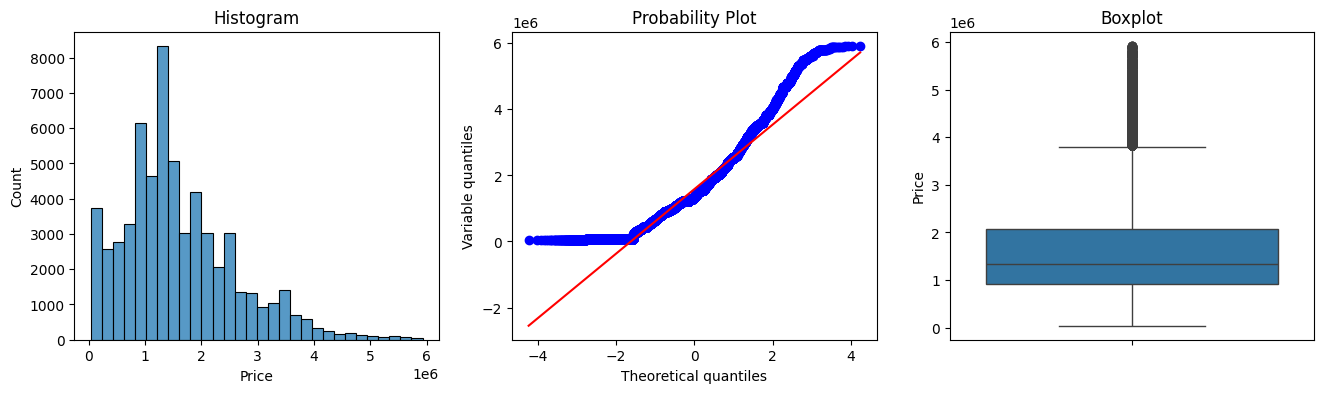

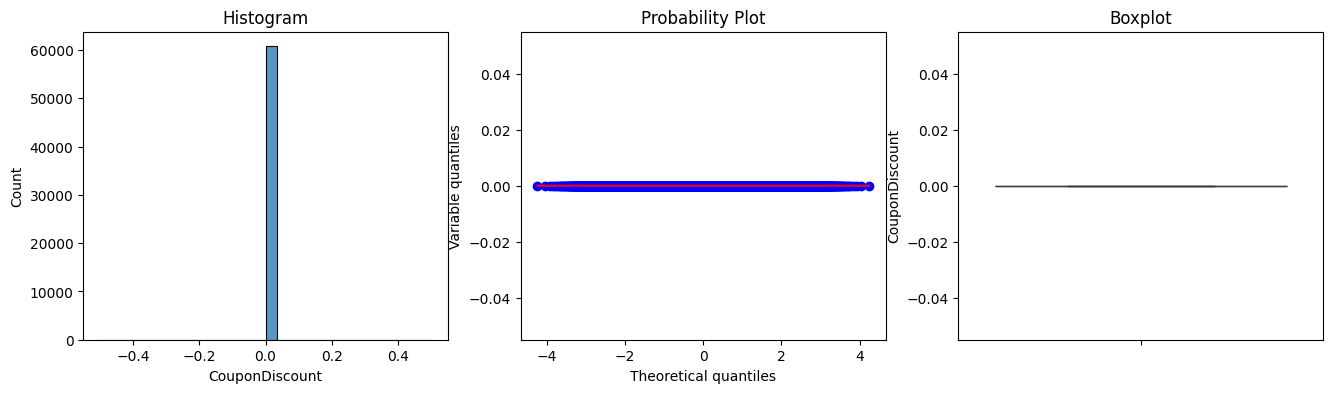

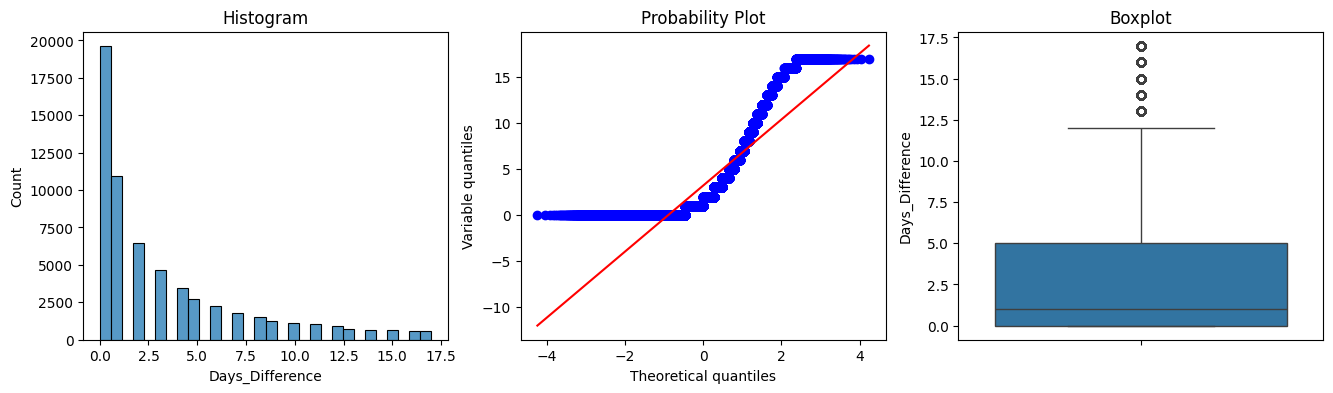

In [14]:
for col in columns_to_check:
  check_plot(train_no_outliers, col)

### Scaling for Logistic Regression (Base Model)

In [15]:
train_df.head()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,Days_Difference
0,4,0,4673500.0,0.0,0.192497,0.136489,1,1,0.183775,1,18
1,2,1,2603000.0,3825.0,0.153596,0.147591,1,0,0.183775,0,12
2,3,0,440000.0,0.0,0.143342,0.144796,1,0,0.132709,0,0
3,3,1,930000.0,0.0,0.102362,0.161992,1,0,0.132709,0,0
4,5,0,10191000.0,0.0,0.153596,0.177178,1,1,0.128494,0,1


In [16]:
train_df.describe()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,Days_Difference
count,80810.000000,80810.000000,8.081000e+04,8.081000e+04,80810.000000,80810.000000,80810.000000,80810.000000,80810.000000,80810.000000,80810.000000
mean,3.155624,0.612635,3.194304e+06,4.802073e+03,0.151268,0.151268,0.992142,0.441245,0.151268,0.151268,5.518018
std,1.072568,0.487151,7.396018e+06,6.473959e+04,0.037757,0.038583,0.088297,0.496539,0.025878,0.358313,8.174971
min,2.000000,0.000000,4.000000e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.085039,0.000000,0.000000
25%,2.000000,0.000000,1.070000e+06,0.000000e+00,0.144768,0.137500,1.000000,0.000000,0.132709,0.000000,0.000000
50%,3.000000,1.000000,1.690000e+06,0.000000e+00,0.153596,0.161992,1.000000,0.000000,0.132709,0.000000,2.000000
75%,4.000000,1.000000,3.014000e+06,0.000000e+00,0.161280,0.161992,1.000000,1.000000,0.183775,0.000000,7.000000
max,5.000000,1.000000,3.837646e+08,1.443333e+07,1.000000,1.000000,1.000000,1.000000,0.183775,1.000000,213.000000


In [17]:
columns_to_scale = ['Price','CouponDiscount','Days_Difference']

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df_scaled[columns_to_scale])

test_df_scaled = test_df.copy()
test_df_scaled[columns_to_scale] = scaler.transform(test_df_scaled[columns_to_scale])


In [18]:
train_df_scaled.describe()

,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,Days_Difference
count,80810.000000,80810.000000,8.081000e+04,8.081000e+04,80810.000000,80810.000000,80810.000000,80810.000000,80810.000000,80810.000000,8.081000e+04
mean,3.155624,0.612635,2.022334e-17,-1.266157e-17,0.151268,0.151268,0.992142,0.441245,0.151268,0.151268,-3.270906e-17
std,1.072568,0.487151,1.000006e+00,1.000006e+00,0.037757,0.038583,0.088297,0.496539,0.025878,0.358313,1.000006e+00
min,2.000000,0.000000,-4.264895e-01,-7.417567e-02,0.000000,0.000000,0.000000,0.000000,0.085039,0.000000,-6.749934e-01
25%,2.000000,0.000000,-2.872245e-01,-7.417567e-02,0.144768,0.137500,1.000000,0.000000,0.132709,0.000000,-6.749934e-01
50%,3.000000,1.000000,-2.033951e-01,-7.417567e-02,0.153596,0.161992,1.000000,0.000000,0.132709,0.000000,-4.303427e-01
75%,4.000000,1.000000,-2.437870e-02,-7.417567e-02,0.161280,0.161992,1.000000,1.000000,0.183775,0.000000,1.812840e-01
max,5.000000,1.000000,5.145642e+01,2.228717e+02,1.000000,1.000000,1.000000,1.000000,0.183775,1.000000,2.538030e+01


### Feature Selection

In [19]:
X_train = train_df_scaled.drop(columns=['Cancel'])
y_train = train_df_scaled['Cancel']

X_test = test_df_scaled.drop(columns=['Cancel'])
y_test = test_df_scaled['Cancel']

## Model Selection

In [20]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    #predict on train
    y_pred_train = clf.predict(X_train)
    y_pred_train_probs = clf.predict_proba(X_train)[:, 1]

    #predict on test
    y_pred_test = clf.predict(X_test)
    y_pred_test_probs = clf.predict_proba(X_test)[:, 1]

    #evaluate on train
    precision_train = precision_score(y_train, y_pred_train, pos_label=1)
    recall_train = recall_score(y_train, y_pred_train, pos_label=1)
    f1_train = f1_score(y_train, y_pred_train, pos_label=1)
    roc_auc_train = roc_auc_score(y_train, y_pred_train_probs)

    #evaluate on test
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    f1_test = f1_score(y_test, y_pred_test, pos_label=1)
    roc_auc_test = roc_auc_score(y_test, y_pred_test_probs)

    #append results to list
    results.append({
        'Model': name,
        'Precision (train)': precision_train,
        'Recall (train)': recall_train,
        'F1-Score (train)': f1_train,
        'ROC AUC (train)': roc_auc_train,
        'Precision (test)': precision_test,
        'Recall (test)': recall_test,
        'F1-Score (test)': f1_test,
        'ROC AUC (test)': roc_auc_test
    })

#create dataframe
results_df = pd.DataFrame(results)
results_df

[LightGBM] [Info] Number of positive: 12224, number of negative: 68586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 80810, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151268 -> initscore=-1.724687
[LightGBM] [Info] Start training from score -1.724687


,Model,Precision (train),Recall (train),F1-Score (train),ROC AUC (train),Precision (test),Recall (test),F1-Score (test),ROC AUC (test)
0,Logistic Regression,0.931976,0.876473,0.903373,0.986747,0.926127,0.884180,0.904667,0.988073
1,K-Nearest Neighbors,0.975973,0.910504,0.942103,0.997270,0.963788,0.895503,0.928392,0.974832
2,Decision Tree,0.998404,0.972595,0.985331,0.999892,0.932042,0.918473,0.925208,0.957634
3,Random Forest,0.995409,0.975540,0.985374,0.999856,0.991429,0.898091,0.942455,0.994245
4,XGBoost,0.998654,0.910340,0.952454,0.998147,0.991039,0.894533,0.940316,0.995264
5,LightGBM,0.999364,0.900196,0.947192,0.997951,0.997466,0.891297,0.941398,0.995243


Among the models evaluated, **XGBoost** stands out as the best-performing model. although it achieved the second highest F1-Score on the test set (0.93) while maintaining a high ROC AUC score (0.99), it has the smallest gap between train and test than other models. indicating both strong precision-recall balance and excellent overall classification ability.

While Decision Tree and Random Forest also performed well, their perfect training scores suggest overfitting. In contrast, XGBoost maintains strong generalization without sacrificing performance.

Therefore, XGBoost is the most reliable model for this classification task.

## Model Training and Evaluation with Random Forest

### Base Model

In [21]:
#retrieve model
xgb = classifiers['XGBoost']

#fit model
xgb.fit(X_train, y_train)

#predict on train and test
base_pred_train = xgb.predict(X_train)
base_pred_train_probs = xgb.predict_proba(X_train)[:, 1]

base_pred_test = xgb.predict(X_test)
base_pred_test_probs = xgb.predict_proba(X_test)[:, 1]

#evaluate
base_train_metrics = {
    'Precision': precision_score(y_train, base_pred_train, pos_label=1),
    'Recall': recall_score(y_train, base_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, base_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, base_pred_train_probs)
}

base_test_metrics = {
    'Precision': precision_score(y_test, base_pred_test, pos_label=1),
    'Recall': recall_score(y_test, base_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, base_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, base_pred_test_probs)
}

base_evaluation_df = pd.DataFrame([base_train_metrics, base_test_metrics], index=['Train', 'Test'])
base_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,0.998654,0.910340,0.952454,0.998147
Test,0.991039,0.894533,0.940316,0.995264


### Tuned XGBoost

To reduce the effect of overfitting, the parameters will be tuned using Randomized Search Cross Validation as follows:


In [22]:
#define model
tuned_xgb = XGBClassifier(random_state=42, eval_metric='logloss')

#define parameters
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

#set up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#set up f1 scoring
f1_scorer = make_scorer(f1_score)

#random search
random_search = RandomizedSearchCV(tuned_xgb, param_grid, n_iter=10, cv=5, scoring=f1_scorer, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

#the best parameter
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1}
Best score:  0.9421398665343595


In [23]:
#retrieve model
tuned_model = random_search.best_estimator_

#predict on train and test
tuned_pred_train = tuned_model.predict(X_train)
tuned_pred_train_probs = tuned_model.predict_proba(X_train)[:, 1]

tuned_pred_test = tuned_model.predict(X_test)
tuned_pred_test_probs = tuned_model.predict_proba(X_test)[:, 1]

#evaluate
tuned_train_metrics = {
    'Precision': precision_score(y_train, tuned_pred_train, pos_label=1),
    'Recall': recall_score(y_train, tuned_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, tuned_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, tuned_pred_train_probs)
}

tuned_test_metrics = {
    'Precision': precision_score(y_test, tuned_pred_test, pos_label=1),
    'Recall': recall_score(y_test, tuned_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, tuned_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, tuned_pred_test_probs)
}

tuned_evaluation_df = pd.DataFrame([tuned_train_metrics, tuned_test_metrics], index=['Train', 'Test'])
tuned_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,0.999189,0.907068,0.950903,0.998092
Test,0.996030,0.892915,0.941658,0.995339


### Tuned XGBoost with SMOTE

Since the target data is imbalance, we can try to improve using oversampling techniques, such as SMOTE:

In [24]:
#define model
smote_xgb = XGBClassifier(random_state=42, eval_metric='logloss')

#define parameters
param_grid = {
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [0, 0.1, 1]
}

#set up pipeline
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),  #apply SMOTE to training data within in each fold
    ('xgb', smote_xgb)
])

#set up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#set up scoring
f1_scorer = make_scorer(f1_score)

#random search
smote_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=cv, scoring=f1_scorer, random_state=42, verbose=1)

#fit
smote_random_search.fit(X_train, y_train)

#the best parameter
print("Best set of hyperparameters: ", smote_random_search.best_params_)
print("Best F1 score: ", smote_random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best set of hyperparameters:  {'xgb__subsample': 1.0, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 1, 'xgb__n_estimators': 300, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1}
Best F1 score:  0.9347584134911131


In [25]:
#retrieve model
smote_model = smote_random_search.best_estimator_

#predict on train and test
smote_pred_train = smote_model.predict(X_train)
smote_pred_train_probs = smote_model.predict_proba(X_train)[:, 1]

smote_pred_test = smote_model.predict(X_test)
smote_pred_test_probs = smote_model.predict_proba(X_test)[:, 1]

#evaluate
smote_train_metrics = {
    'Precision': precision_score(y_train, smote_pred_train, pos_label=1),
    'Recall': recall_score(y_train, smote_pred_train, pos_label=1),
    'F1-Score': f1_score(y_train, smote_pred_train, pos_label=1),
    'ROC AUC': roc_auc_score(y_train, smote_pred_train_probs)
}

smote_test_metrics = {
    'Precision': precision_score(y_test, smote_pred_test, pos_label=1),
    'Recall': recall_score(y_test, smote_pred_test, pos_label=1),
    'F1-Score': f1_score(y_test, smote_pred_test, pos_label=1),
    'ROC AUC': roc_auc_score(y_test, smote_pred_test_probs)
}

smote_evaluation_df = pd.DataFrame([smote_train_metrics, smote_test_metrics], index=['Train', 'Test'])
smote_evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Train,0.986092,0.922202,0.953077,0.997968
Test,0.569980,1.000000,0.726098,0.925845


### Model Analysis

In [26]:
evaluation_df = pd.DataFrame([base_train_metrics, base_test_metrics,
                              tuned_train_metrics, tuned_test_metrics,
                              smote_train_metrics,smote_test_metrics],
                             index = ['Base XGBoost Train', 'Base XGBoost Test',
                                      'Tuned XGBoost(without SMOTE) Train', 'Tuned XGBoost(without SMOTE) Train',
                                      'Tuned XGBoost with SMOTE Train', 'Tuned XGBoost with SMOTE Test'])
evaluation_df

,Precision,Recall,F1-Score,ROC AUC
Base XGBoost Train,0.998654,0.910340,0.952454,0.998147
Base XGBoost Test,0.991039,0.894533,0.940316,0.995264
Tuned XGBoost(without SMOTE) Train,0.999189,0.907068,0.950903,0.998092
Tuned XGBoost(without SMOTE) Train,0.996030,0.892915,0.941658,0.995339
Tuned XGBoost with SMOTE Train,0.986092,0.922202,0.953077,0.997968
Tuned XGBoost with SMOTE Test,0.569980,1.000000,0.726098,0.925845


**Observations:**

- Tuned XGBoost shows no improvement over the base model in all metrics (precision, recall, F1-score, and ROC-AUC), indicating that base XGBoost model is a better balance between precision and recall. It shows that hyperparameter tuning unsuccessfully enhanced the model's performance without compromising generalization.
- and SMOTE implementation slightly reduces the overall performance (precision, recall, F1-score, ROC-AUC drops). This is likely due to introducing noise in the synthetic samples, making it less effective compared to the tuned model without SMOTE.


The **Base XGBoost ** is the best-performing model. It provides the highest recall, F1-Score, and ROC AUC, and second highest in precision. indicating a robust and balanced performance.

<Figure size 800x600 with 0 Axes>

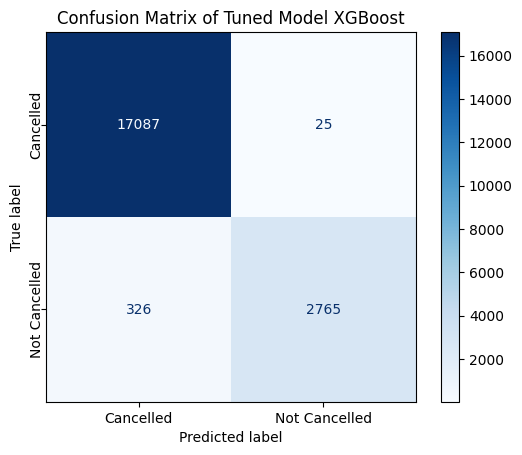

In [28]:
#confusion matrix of base XGBoost

cm_based = confusion_matrix(y_test, base_pred_test)
base_display = ConfusionMatrixDisplay(confusion_matrix=cm_based, display_labels=['Cancelled', 'Not Cancelled'])

plt.figure(figsize=(8, 6))
base_display.plot(cmap='Blues', values_format='d')
plt.yticks(rotation=90, ha='center', va='center')
plt.title('Confusion Matrix of Tuned Model XGBoost')
plt.show()

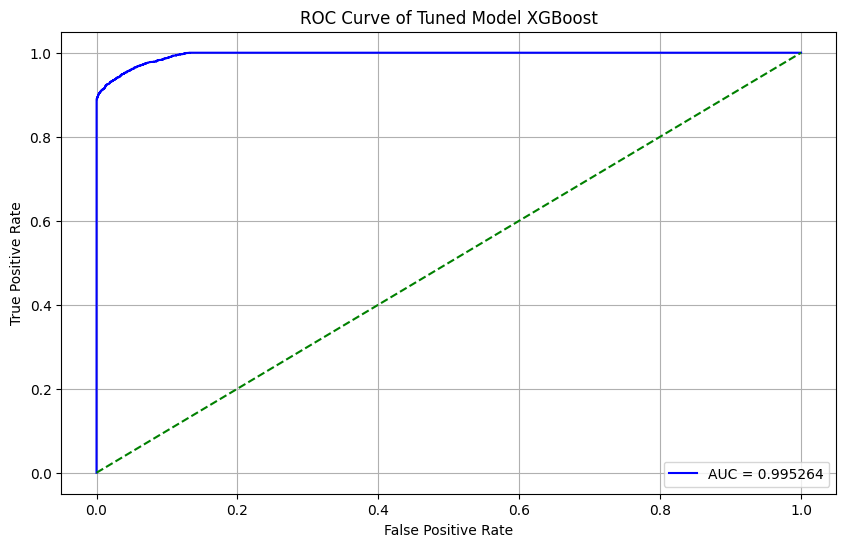

In [29]:
#check ROC-AUC curve and result

base_fpr, base_tpr, base_thresholds = roc_curve(y_test, base_pred_test_probs)
base_roc_auc = roc_auc_score(y_test, base_pred_test_probs)

plt.figure(figsize=(10, 6))
plt.plot(base_fpr, base_tpr, color='blue', label=f'AUC = {base_roc_auc:.6f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.title('ROC Curve of Tuned Model XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

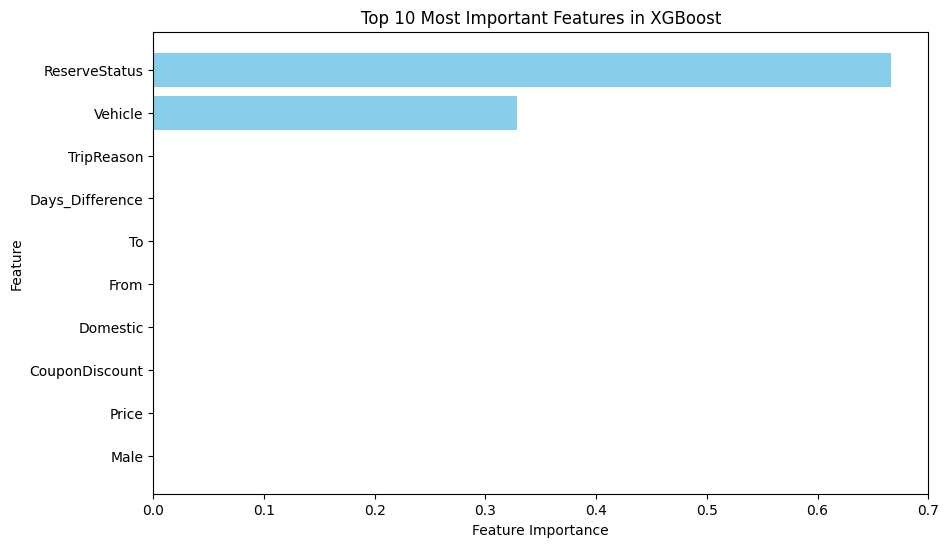

           Feature  Importance
0    ReserveStatus    0.666669
8          Vehicle    0.328763
7       TripReason    0.000780
9  Days_Difference    0.000682
5               To    0.000649
4             From    0.000591
6         Domestic    0.000569
3   CouponDiscount    0.000504
2            Price    0.000463
1             Male    0.000329


In [32]:
importances = xgb.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

top_10_features = feature_importance_df.head(10).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features in XGBoost')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

print(top_10_features)

## Actionable Insights Based on Feature Importance for Ticket Travel Cancellation Prediction

**1. Reserve Status:** The most critical factor influencing cancellations (66.7% importance)

Implement real-time monitoring of reservation status changes as early warning indicators
Develop automated interventions for reservations showing "at-risk" status patterns
Create targeted retention offers for reservations with unstable status history

**2. Vehicle Type:** Second most important factor (32.9% impact)

Analyze cancellation patterns by aircraft type and adjust scheduling accordingly
For vehicle types with high cancellation rates, implement stricter deposit requirements
Consider reassigning less reliable aircraft to routes with lower cancellation sensitivity

**3. Trip Reason:** Business vs leisure travel shows meaningful impact

Develop tailored cancellation policies based on travel purpose
For business travelers, offer flexible rescheduling options instead of cancellations
For leisure travelers, implement non-refundable deposit strategies during peak seasons

**4. Days Difference:** Booking lead time affects cancellation likelihood

Implement dynamic cancellation fees that increase as departure date approaches
Offer "cancel for any reason" insurance for bookings made far in advance
Create early-bird incentives with moderate cancellation penalties

**5. Destination (To):** Specific destinations show different cancellation patterns

Identify high-cancellation destinations and analyze competitive landscape
For problematic routes, consider adjusting inventory allocation or implementing minimum stay requirements
Develop destination-specific promotional packages to reduce cancellations

**6. Origin (From):** Departure cities influence cancellation behavior

Focus customer retention efforts on origins with historically high cancellation rates
Analyze local market conditions in high-cancellation origin cities
Develop origin-specific marketing campaigns addressing local cancellation triggers

**7. Domestic vs International:** Route type impacts cancellation probability

Implement differentiated cancellation policies for domestic and international flights
For domestic routes with higher cancellations, consider shorter booking windows
For international flights, offer more flexible change options to retain revenue

**8. Coupon Discount:** Discount levels correlate with cancellation behavior

Avoid excessive discounts that may attract unreliable customers
Implement moderate discount strategies with clear cancellation terms
Bundle discounts with non-refundable components to increase commitment

**9. Price:** Ticket price influences cancellation decisions

For low-priced tickets, add value through bundled services to increase stickiness
Implement tiered cancellation fees based on ticket price brackets
Use dynamic pricing to manage cancellation risk across different price points

**10. Gender**: Male passengers show slightly different cancellation patterns

While the impact is minimal, consider gender in personalized communication strategies
Develop targeted messaging based on demographic insights where relevant
General Recommendations:

---

**General Recommendations:**
Focus 99% of cancellation prevention efforts on managing ReserveStatus and Vehicle factors
Implement a real-time cancellation risk scoring system using these top predictors
Develop automated intervention workflows for high-risk reservations
Regularly monitor and update feature importance as market conditions change
Use these insights to optimize inventory management and overbooking strategies
Priority Actions:

Immediate: Build ReserveStatus monitoring dashboard

Short-term: Analyze Vehicle-specific cancellation patterns

Medium-term: Develop targeted policies for top 3 factors

Long-term: Implement machine learning-driven risk management system
